<a href="https://colab.research.google.com/github/kmcguigan1/MNIST-Convs-Torch/blob/lily-dev/MNIST_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [1]:
# import statements
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# use Cuda: change runtime environment to T4 GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
# initialize parameters

# mean and standard deviation corresponding to the MNIST dataset
mnist_mean = 0.1307
mnist_std_dev = 0.3081

# train and test batch sizes
train_batch_size = 512
test_batch_size = 1000

# learning rate
lr = 0.01
# number of epochs
epochs = 10

Load and Plot Dataset

In [4]:
def plot_mnist(data):
    # plot a subset of MNIST examples
    fig, axs = plt.subplots(4, 5, figsize=(5, 6))

    plot_images = []
    plot_labels = []

    for i, ax in enumerate(axs.flatten(), start=1000):
        (image, label) = data[i]

        # save the data
        plot_images.append(image)
        plot_labels.append(label)

        # plot each image
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

MNIST EXAMPLES WITHOUT AUGMENTATION


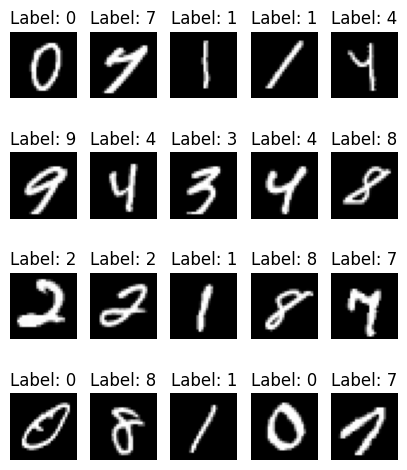

MNIST EXAMPLES WITH AUGMENTATION


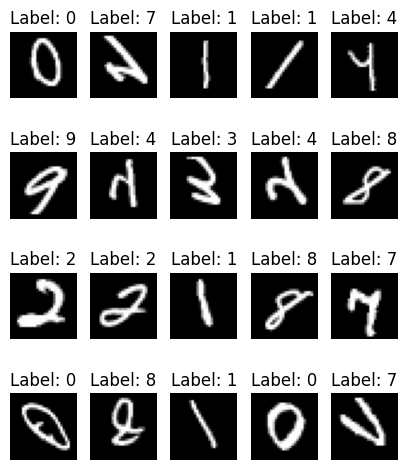

In [5]:
### No augmentation ###
print("MNIST EXAMPLES WITHOUT AUGMENTATION")

# train and test image transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev)
])

# train and test data
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=test_transform)

# train and test data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size)

# plot examples of training data
plot_mnist(train_data)

### Example augmentation ###
print("MNIST EXAMPLES WITH AUGMENTATION")

# train and test image transforms
train_transform_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev),
    torchvision.transforms.RandomVerticalFlip()
])

test_transform_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev)
])

# train and test data
train_data_aug = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=train_transform_aug)
test_data_aug = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=test_transform_aug)

# train and test data loaders
train_loader_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=train_batch_size, shuffle=True)
test_loader_aug = torch.utils.data.DataLoader(test_data_aug, batch_size=test_batch_size)

# plot examples of training data
plot_mnist(train_data_aug)

Model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layers
        self.input_conv = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.hidden_conv = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.output_conv = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)

        # max pooling layers
        self.max_pooling1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        self.max_pooling2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        self.output_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # dense layers
        self.dense1 = nn.Linear(128, 10)

        # activations
        self.relu = nn.ReLU()
        #self.softmax = nn.Softmax()

    def forward(self, x):
        # convolution
        x = self.input_conv(x)
        x = self.relu(x)
        # sub-sampling
        x = self.max_pooling1(x)
        # convolution
        x = self.hidden_conv(x)
        x = self.relu(x)
        # sub-sampling
        x = self.max_pooling2(x)
        # convolution
        x = self.output_conv(x)
        x = self.relu(x)
        # sub-sampling
        x = self.output_pool(x)
        # classification
        x = x.squeeze()
        x = self.dense1(x)
        return x

In [7]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    # initialize parameters
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE) # included so we can use Cuda
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader): # 1. fetch next batch of data
        optimizer.zero_grad() # 2. zero the parameter gradients
        inputs = inputs.to(DEVICE) # for use of Cuda
        outputs = model(inputs) # 3. compute model outputs
        loss = loss_fn(outputs, targets.to(DEVICE)) # 4. compute the loss between model outputs and targets (using Cuda)
        loss.backward() # 5. backpropagation
        optimizer.step() # 6. gradient descent


        # Track some values to compute statistics
        total_loss += loss.item()
        # compute the model predictions
        preds = torch.argmax(outputs, dim=-1) # class with the highest output is the prediction

        # track predictions and targets (using Cuda)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    # compute the accuracy score
    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)

    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [8]:
def test(model, test_loader, loss_fn, epoch=-1):
    # initialize parameters
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE) # included so we can use Cuda
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader): # 1. fetch next batch of data
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE)) # 3. compute model predictions (using Cuda)
            loss = loss_fn(outputs, targets.to(DEVICE)) # 4. compute the loss between model outputs and targets (using Cuda)

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1) # class with the highest output is the prediction

            # track predictions and targets (using Cuda)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    # compute the accuracy score
    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [9]:
torch.manual_seed(0)
model = CNN()
optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.CrossEntropyLoss()

In [10]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for epoch in range(epochs):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

Epoch 1 done. Average train loss = 1.21, average train accuracy = 57.368%
Epoch 1 done. Average test loss = 0.40, average test accuracy = 87.960%
Epoch 2 done. Average train loss = 0.30, average train accuracy = 90.775%
Epoch 2 done. Average test loss = 0.24, average test accuracy = 92.500%
Epoch 3 done. Average train loss = 0.21, average train accuracy = 93.530%
Epoch 3 done. Average test loss = 0.15, average test accuracy = 95.370%
Epoch 4 done. Average train loss = 0.17, average train accuracy = 94.852%
Epoch 4 done. Average test loss = 0.15, average test accuracy = 95.110%
Epoch 5 done. Average train loss = 0.14, average train accuracy = 95.517%
Epoch 5 done. Average test loss = 0.13, average test accuracy = 95.880%
Epoch 6 done. Average train loss = 0.13, average train accuracy = 96.092%
Epoch 6 done. Average test loss = 0.11, average test accuracy = 96.550%
Epoch 7 done. Average train loss = 0.11, average train accuracy = 96.507%
Epoch 7 done. Average test loss = 0.09, average te

Plot Results

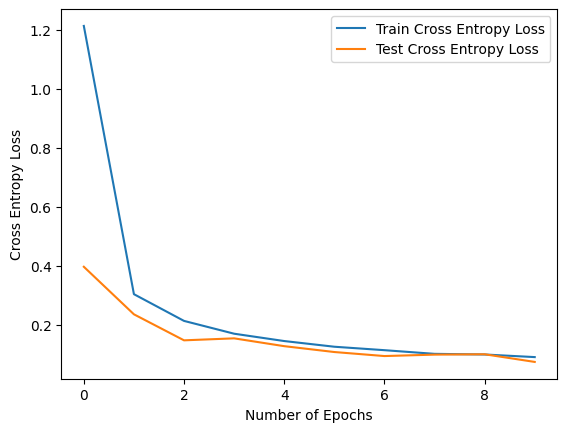

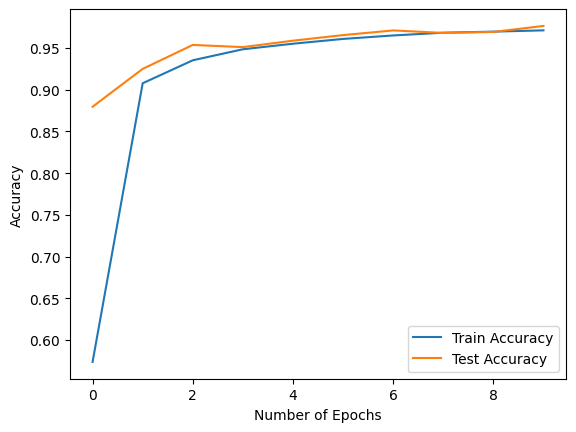

In [14]:
def plot_stats(train, test, title):
    plt.plot(train, label='Train ' + title)
    plt.plot(test, label='Test ' + title)
    plt.xlabel("Number of Epochs")
    plt.ylabel(title)
    plt.legend()
    plt.show()

plot_stats(train_losses, test_losses, "Cross Entropy Loss")
plot_stats(train_metrics, test_metrics, "Accuracy")